# Hudba a neurónové siete
## Bakárska práca
### Peter Oliver Kolek

In [124]:
from mido import MidiFile, MidiTrack, MetaMessage, bpm2tempo, Message
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from scipy.stats import gmean

In [2]:
def open_midi(midi_file):
    # open midi file
    mid = MidiFile(midi_file, clip=True)

    drum_track_number = 0
    # find track number of drums
    for i in range(len(mid.tracks)):
        for j in range(len(mid.tracks[i])):
            if mid.tracks[i][j].is_meta:
                continue
            if mid.tracks[i][j].channel == 9:
                drum_track_number = i
                break
    print("Drum track number: ", str(drum_track_number))
    return mid, mid.tracks[drum_track_number]

In [3]:
def get_transcription(drum_track, mid):
    # find ticks per beat, and divide it to Thirty-Second 32 notes
    ticks_per_beat_in_32_notes = mid.ticks_per_beat / 8
    print(ticks_per_beat_in_32_notes)
    # change notes time to stick it to 32 notes
    tmp_time = 0
    time_with_note = {}
    for i, message in enumerate(drum_track):
        # find time how it goes through song
        tmp_time += drum_track[i].time
        message.time = round(tmp_time / ticks_per_beat_in_32_notes)
#         print("i: ", i, "msg time: ", message.time, "tmp time: ", tmp_time, "Msg_type: ", message.type)
        # make velocity of notes same
        if message.type == 'note_on':
            if message.velocity > 0:
                message.velocity = 1

    # crating DataFrame for notes sticked to 32s and filter only note_on notes
    transcription = pd.DataFrame(m.dict() for m in drum_track)
    transcription = transcription[transcription.type == 'note_on']
    # modify table to have columns for every note and lines with time (32 notes as they folow the song)
    transcription = transcription.pivot_table(index='time', columns='note', values='velocity', fill_value=0)
    # because we have 4/4 tempo, we have to add notes to have folowing 32 notes and empty values we fill with zeros
    transcription = transcription.reindex(pd.RangeIndex(transcription.index.max() + 1)).fillna(0).sort_index()
    # retype to int
    transcription = transcription.astype(int)
    transcription.columns = transcription.columns.astype(int)
    transcription = transcription.reset_index(drop=True)
    return transcription

In [4]:
def create_midi(tempo, transcription, ticks_per_beat, file_name):
    # create new midi file
    new_mid = MidiFile()
    new_mid.ticks_per_beat = ticks_per_beat
    meta_track = MidiTrack()
    new_mid.tracks.append(meta_track)

    # necessary meta track
    meta_track.append(MetaMessage(type='track_name', name='meta_track', time=0))
    meta_track.append(MetaMessage(type='time_signature', numerator=4, denominator=4, clocks_per_click=24,
                                  notated_32nd_notes_per_beat=8, time=0))
    meta_track.append(MetaMessage(type='set_tempo', tempo=bpm2tempo(tempo), time=0))

    drum_track_new = MidiTrack()
    new_mid.tracks.append(drum_track_new)

    # apend notes to drum track
    ticks_per_32note = int(ticks_per_beat/8)
    notes_from_last_message = 0
    for i, note in enumerate(transcription):
        if i == 0:
            for idx, inst in enumerate(note):
                if inst == 0:
                    continue
                drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
            continue
        else:
            if sum(note) < 1:
                notes_from_last_message += 1
                continue
            else:
                notes_from_last_message += 1

            same_note_count = 0
            for idx, inst in enumerate(note):
                if inst == 0:
                    pass
                # if there are more notes at the same time played, they must have time 0
                elif same_note_count == 0:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80,
                                                  time=notes_from_last_message * ticks_per_32note))
                    same_note_count += 1
                else:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
                    same_note_count += 1
            notes_from_last_message = 0
    print(new_mid)
    new_mid.save(file_name)

In [5]:
mid, drum_track = open_midi('./RHCP_midi/FortuneFaded.mid')

Drum track number:  4


In [6]:
transcription = get_transcription(drum_track, mid)
# print(transcription)
# for i in transcription:
#     print(i)
# find all instruments in song
instruments = transcription.columns.tolist()

120.0


In [7]:
inputs_list = []
outputs_list = []
sequence_len = 64
raw_notes = transcription.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    inputs_list.append(raw_notes[input_start:input_end])
    outputs_list.append(raw_notes[output_start:output_end])

outputs_list = list(np.array(outputs_list).reshape(-1, np.array(outputs_list).shape[-1]))

inputs_list = np.array(inputs_list)
outputs_list = np.array(outputs_list)

output_shape = outputs_list.shape[1]

In [8]:
dropout = 0.2

# very very very basic LSTM model
model = Sequential()
model.add(LSTM(sequence_len, input_shape=(sequence_len, len(instruments)), return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, dropout=dropout))
model.add(Dense(output_shape, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.BinaryCrossentropy()])
model.summary()
mc = ModelCheckpoint(filepath='./new_encode_1st_try.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(inputs_list, outputs_list, epochs=200, callbacks=mc, validation_split=0.1, verbose=1, shuffle=False)

2022-02-15 21:29:21.166051: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 64)            18176     
                                                                 
 lstm_1 (LSTM)               (None, 64, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 84,614
Trainable params: 84,614
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
87/88 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.4149 - binary_crossentropy: 0.3067
Epoch 1: val_loss improved from inf to 0.28029, saving mode

Epoch 20/200
87/88 [============================>.] - ETA: 0s - loss: 0.1502 - accuracy: 0.6598 - binary_crossentropy: 0.1502
Epoch 20: val_loss improved from 0.18568 to 0.18551, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 68ms/step - loss: 0.1503 - accuracy: 0.6599 - binary_crossentropy: 0.1503 - val_loss: 0.1855 - val_accuracy: 0.5016 - val_binary_crossentropy: 0.1855
Epoch 21/200
87/88 [============================>.] - ETA: 0s - loss: 0.1493 - accuracy: 0.6918 - binary_crossentropy: 0.1493
Epoch 21: val_loss improved from 0.18551 to 0.18497, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 64ms/step - loss: 0.1494 - accuracy: 0.6918 - binary_crossentropy: 0.1494 - val_loss: 0.1850 - val_accuracy: 0.7492 - val_binary_crossentropy: 0.1850
Epoch 22/200
88/88 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.7276 - binary_crossentropy: 0.1488
Epoch 22: val_loss did not improve from 0.18497


88/88 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.6455 - binary_crossentropy: 0.1090
Epoch 41: val_loss did not improve from 0.16747
88/88 [==============================] - 5s 62ms/step - loss: 0.1090 - accuracy: 0.6455 - binary_crossentropy: 0.1090 - val_loss: 0.1735 - val_accuracy: 0.5402 - val_binary_crossentropy: 0.1735
Epoch 42/200
87/88 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.6670 - binary_crossentropy: 0.1042
Epoch 42: val_loss improved from 0.16747 to 0.16445, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 63ms/step - loss: 0.1044 - accuracy: 0.6667 - binary_crossentropy: 0.1044 - val_loss: 0.1644 - val_accuracy: 0.5659 - val_binary_crossentropy: 0.1644
Epoch 43/200
87/88 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.6656 - binary_crossentropy: 0.1030
Epoch 43: val_loss improved from 0.16445 to 0.16094, saving model to ./new_encode_1st_try.h5
88/88 [======

Epoch 62/200
87/88 [============================>.] - ETA: 0s - loss: 0.0816 - accuracy: 0.6591 - binary_crossentropy: 0.0816
Epoch 62: val_loss did not improve from 0.13033
88/88 [==============================] - 6s 65ms/step - loss: 0.0817 - accuracy: 0.6591 - binary_crossentropy: 0.0817 - val_loss: 0.1321 - val_accuracy: 0.6817 - val_binary_crossentropy: 0.1321
Epoch 63/200
87/88 [============================>.] - ETA: 0s - loss: 0.0802 - accuracy: 0.6760 - binary_crossentropy: 0.0802
Epoch 63: val_loss improved from 0.13033 to 0.12748, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 63ms/step - loss: 0.0803 - accuracy: 0.6760 - binary_crossentropy: 0.0803 - val_loss: 0.1275 - val_accuracy: 0.7395 - val_binary_crossentropy: 0.1275
Epoch 64/200
87/88 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.6739 - binary_crossentropy: 0.0798
Epoch 64: val_loss improved from 0.12748 to 0.12726, saving model to ./new_encode_1st_try.h5


87/88 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.5532 - binary_crossentropy: 0.0509
Epoch 82: val_loss improved from 0.05322 to 0.05024, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 65ms/step - loss: 0.0509 - accuracy: 0.5538 - binary_crossentropy: 0.0509 - val_loss: 0.0502 - val_accuracy: 0.5916 - val_binary_crossentropy: 0.0502
Epoch 83/200
88/88 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.5441 - binary_crossentropy: 0.0484
Epoch 83: val_loss improved from 0.05024 to 0.05001, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 63ms/step - loss: 0.0484 - accuracy: 0.5441 - binary_crossentropy: 0.0484 - val_loss: 0.0500 - val_accuracy: 0.5402 - val_binary_crossentropy: 0.0500
Epoch 84/200
87/88 [============================>.] - ETA: 0s - loss: 0.0456 - accuracy: 0.5413 - binary_crossentropy: 0.0456
Epoch 84: val_loss improved from 0.05001 to 0.04873, saving m

87/88 [============================>.] - ETA: 0s - loss: 0.0394 - accuracy: 0.6006 - binary_crossentropy: 0.0394
Epoch 103: val_loss did not improve from 0.04169
88/88 [==============================] - 6s 63ms/step - loss: 0.0394 - accuracy: 0.6011 - binary_crossentropy: 0.0394 - val_loss: 0.0435 - val_accuracy: 0.5852 - val_binary_crossentropy: 0.0435
Epoch 104/200
88/88 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.5882 - binary_crossentropy: 0.0419
Epoch 104: val_loss did not improve from 0.04169
88/88 [==============================] - 6s 65ms/step - loss: 0.0419 - accuracy: 0.5882 - binary_crossentropy: 0.0419 - val_loss: 0.0435 - val_accuracy: 0.5820 - val_binary_crossentropy: 0.0435
Epoch 105/200
88/88 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.5878 - binary_crossentropy: 0.0434
Epoch 105: val_loss did not improve from 0.04169
88/88 [==============================] - 6s 65ms/step - loss: 0.0434 - accuracy: 0.5878 - binary_c

Epoch 125/200
87/88 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.6250 - binary_crossentropy: 0.0379
Epoch 125: val_loss improved from 0.03992 to 0.03981, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 64ms/step - loss: 0.0379 - accuracy: 0.6258 - binary_crossentropy: 0.0379 - val_loss: 0.0398 - val_accuracy: 0.5884 - val_binary_crossentropy: 0.0398
Epoch 126/200
88/88 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.6283 - binary_crossentropy: 0.0383
Epoch 126: val_loss did not improve from 0.03981
88/88 [==============================] - 6s 63ms/step - loss: 0.0383 - accuracy: 0.6283 - binary_crossentropy: 0.0383 - val_loss: 0.0408 - val_accuracy: 0.5852 - val_binary_crossentropy: 0.0408
Epoch 127/200
88/88 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.6197 - binary_crossentropy: 0.0379
Epoch 127: val_loss did not improve from 0.03981
88/88 [==============================] 

Epoch 147/200
88/88 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.6004 - binary_crossentropy: 0.0364
Epoch 147: val_loss improved from 0.03977 to 0.03873, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 66ms/step - loss: 0.0364 - accuracy: 0.6004 - binary_crossentropy: 0.0364 - val_loss: 0.0387 - val_accuracy: 0.5338 - val_binary_crossentropy: 0.0387
Epoch 148/200
88/88 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.5903 - binary_crossentropy: 0.0336
Epoch 148: val_loss did not improve from 0.03873
88/88 [==============================] - 6s 67ms/step - loss: 0.0336 - accuracy: 0.5903 - binary_crossentropy: 0.0336 - val_loss: 0.0411 - val_accuracy: 0.5788 - val_binary_crossentropy: 0.0411
Epoch 149/200
88/88 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.6097 - binary_crossentropy: 0.0333
Epoch 149: val_loss improved from 0.03873 to 0.03841, saving model to ./new_encode_1st_t

Epoch 169/200
88/88 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.5502 - binary_crossentropy: 0.0481
Epoch 169: val_loss improved from 0.03768 to 0.03725, saving model to ./new_encode_1st_try.h5
88/88 [==============================] - 6s 63ms/step - loss: 0.0481 - accuracy: 0.5502 - binary_crossentropy: 0.0481 - val_loss: 0.0372 - val_accuracy: 0.5788 - val_binary_crossentropy: 0.0372
Epoch 170/200
87/88 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.4454 - binary_crossentropy: 0.2370
Epoch 170: val_loss did not improve from 0.03725
88/88 [==============================] - 6s 64ms/step - loss: 0.2370 - accuracy: 0.4452 - binary_crossentropy: 0.2370 - val_loss: 0.2960 - val_accuracy: 0.1608 - val_binary_crossentropy: 0.2960
Epoch 171/200
87/88 [============================>.] - ETA: 0s - loss: 0.2070 - accuracy: 0.4404 - binary_crossentropy: 0.2070
Epoch 171: val_loss did not improve from 0.03725
88/88 [==============================] 

87/88 [============================>.] - ETA: 0s - loss: 0.0312 - accuracy: 0.5787 - binary_crossentropy: 0.0312
Epoch 191: val_loss did not improve from 0.03725
88/88 [==============================] - 6s 66ms/step - loss: 0.0312 - accuracy: 0.5789 - binary_crossentropy: 0.0312 - val_loss: 0.0405 - val_accuracy: 0.4437 - val_binary_crossentropy: 0.0405
Epoch 192/200
88/88 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.5964 - binary_crossentropy: 0.0313
Epoch 192: val_loss did not improve from 0.03725
88/88 [==============================] - 6s 64ms/step - loss: 0.0313 - accuracy: 0.5964 - binary_crossentropy: 0.0313 - val_loss: 0.0404 - val_accuracy: 0.3633 - val_binary_crossentropy: 0.0404
Epoch 193/200
87/88 [============================>.] - ETA: 0s - loss: 0.0334 - accuracy: 0.5858 - binary_crossentropy: 0.0334
Epoch 193: val_loss did not improve from 0.03725
88/88 [==============================] - 6s 64ms/step - loss: 0.0334 - accuracy: 0.5857 - binary_c

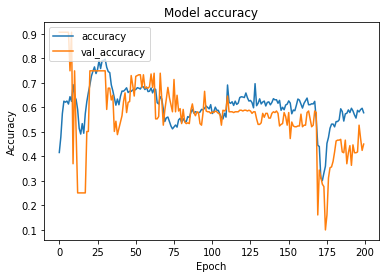

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

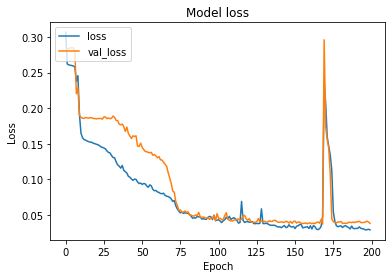

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')

plt.show()

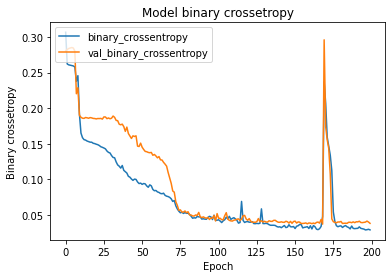

In [11]:
plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('Model binary crossetropy')
plt.ylabel('Binary crossetropy')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy', 'val_binary_crossentropy'], loc='upper left')

plt.show()

In [12]:
# predict new notes
prediction = model.predict(inputs_list, verbose=0)
# round prediction to 1 or 0
prediction = np.around(prediction)
# retype it to int
prediction = prediction.astype(int)


In [13]:
bpm = 120
file_name = "./output/output.mid"
create_midi(bpm, prediction, mid.ticks_per_beat, file_name)
create_midi(bpm, transcription.values, mid.ticks_per_beat, "./output/transcription.mid")

MidiFile(type=1, ticks_per_beat=960, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='meta_track', time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('set_tempo', tempo=500000, time=0)]),
  MidiTrack([
    Message('note_on', channel=9, note=40, velocity=80, time=0),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', channel=9, note=40, velocity=80, time=240),
    Message('note_on', 

In [133]:
def bleu_metric_complete_lines(candidate, reference):
    correct_lines = 0
    for i,c in enumerate(candidate):
        # line of candidate is the same as reference
        if (c == reference[i]).all() == True:
            correct_lines += 1
    
    # probability of correct lines
    return correct_lines/len(reference)

def bleu_metric(candidate, reference, length_of_line):
    correct_lines = 0
    probabilities = []
    for i,c in enumerate(candidate):
        # how many notes are correct in single line
        tmp = ((c == reference[i]) == True).sum()
        # probability of correct notes in single line
        probabilities.append(tmp/length_of_line)
    
    # geometric mean of probabilities
    return gmean(probabilities)

In [134]:
candidate = prediction.copy()
reference = transcription.values.copy()

In [135]:
bleu_metric_complete_lines(candidate, reference)

0.8774091627172196

In [136]:
bleu_metric(candidate, reference, length_of_line=len(instruments))

0.9669129719375206